In [1]:
import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from galerkin import DGMNet
from branch import Net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Implementation with closed-form formula given by Borodin

In [2]:
upper_bound, lower_bound = 2, -10000

def conditional_probability_to_survive(t, x, y, k_arr=range(-5, 5)):
    ans = 0
    for k in k_arr:
        ans += (
                torch.exp(((y - x) ** 2 - (y - x + 2 * k * (upper_bound - lower_bound)) ** 2) / (2 * t))
                - torch.exp(((y - x) ** 2 - (y + x - 2 * lower_bound + 2 * k * (upper_bound - lower_bound)) ** 2) / (2 * t))
        )
    return ans.prod(dim=0)

def is_x_inside(x):
    return torch.logical_and(lower_bound <= x, x <= upper_bound).all(dim=0)

## Example 1: heat equation

The heat equation
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega,
\end{cases}
$$
where
$A = [a, b]$
and
$\Omega = (\infty, \bar{x}]$,
admits the closed-form solution of
$$
u_A(t, x) = 
\Phi\left(\frac{b - x}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{2*\bar{x} - a - x}{\sqrt{\nu(T-t)}}\right)
+ \Phi\left(\frac{2*\bar{x} - b - x}{\sqrt{\nu(T-t)}}\right).
$$
In particular, when $\bar{x} \to \infty$, the solution becomes
$$
u_A(t, x) = 
\Phi\left(\frac{b - x}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x}{\sqrt{\nu(T-t)}}\right).
$$

In [3]:
nu = 1
y, eps = 0, 1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return torch.zeros_like(y[0])

def phi_example(x):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

def exact_example(t, x, T, with_bound=False):
    if t == T:
        return np.logical_and(x[0] <= b, x[0] >= a)
    else:
        normal_std = math.sqrt(nu * (T - t))
        prob_without_bound = norm.cdf((b - x[0]) / normal_std) - norm.cdf((a - x[0]) / normal_std)
        if not with_bound:
            # without bound
            return prob_without_bound
        # with bound
        return (
            prob_without_bound
            - norm.cdf((2 * upper_bound - a - x[0]) / normal_std)
            + norm.cdf((2 * upper_bound - b - x[0]) / normal_std)
        )

t_lo, x_lo, x_hi, n = 0., 0., upper_bound, 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 1
true = exact_example(t_lo, grid_d_dim, T)
true_with_bound = exact_example(t_lo, grid_d_dim, T, with_bound=True)
terminal = exact_example(T, grid_d_dim, T)

Patch 0: generation of samples take 0.10483694076538086 seconds.


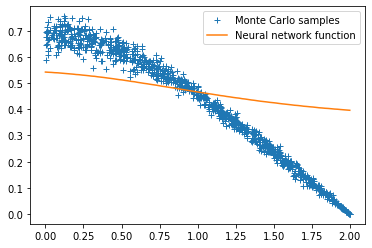

Patch 0: epoch 0 with loss 1.5870168209075928


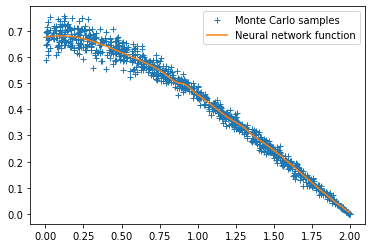

Patch 0: epoch 500 with loss 0.0005041980766691267


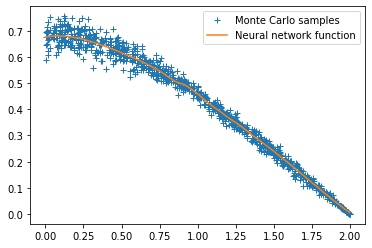

Patch 0: epoch 1000 with loss 0.0004999650409445167


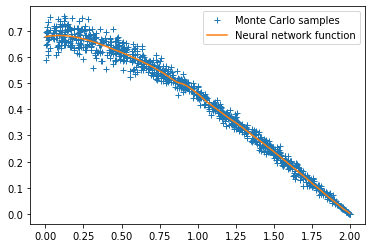

Patch 0: epoch 1500 with loss 0.0004967030836269259


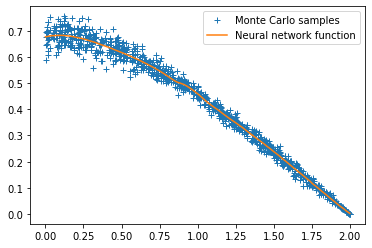

Patch 0: epoch 2000 with loss 0.0004964444669894874


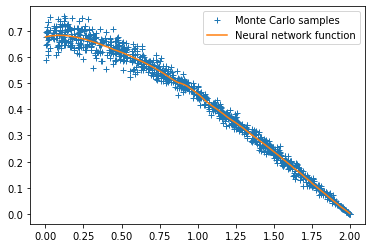

Patch 0: epoch 2500 with loss 0.000496340508107096


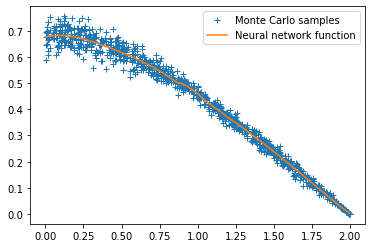

Patch 0: epoch 2999 with loss 0.0004966412670910358
Patch 0: training of neural network with 3000 epochs take 12.456314086914062 seconds.


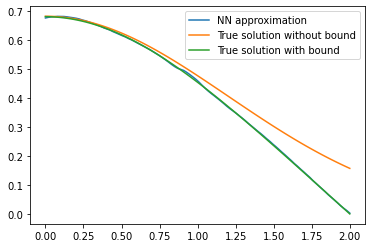

In [4]:
# define NN and train
model = Net(
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=conditional_probability_to_survive,
    is_x_inside=is_x_inside,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    verbose=True,
    nu=nu,
)
model.train_and_eval(debug_mode=True)

# plot NN solution for comparison
nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=0)
        .detach()
        .cpu()
        .numpy()
)
plt.plot(grid, nn, label="NN approximation")
plt.plot(grid, true, label="True solution without bound")
plt.plot(grid, true_with_bound, label="True solution with bound")
plt.legend()
plt.show()

# Implementation with DGM

We are interested in the following quantity
$$
p(T, x, y) = \mathbb{P}_x(X_t \in \Omega \text{ for all } t \le T | X_T=y),
$$
where $\Omega \subset \mathbb{R}^d$.
Such term can be approximated by
$p(T, x, y) \approx \frac{\mathbb{P}_x(X_T \in A \ \text{ and } \ X_t \in \Omega \text{ for all } t \le T)}{\mathbb{P}_x(X_T \in A)} = \frac{u_A(0, x)}{\mathbb{P}_x(X_T \in A)}$,
where $A$ is a small neighborhood containing $y$
and $u_A$ satisfies the following PDE:
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega.
\end{cases}
$$

For simplicity, we first deal with the case $\nu=1$, $d=1$, $\Omega = (\infty, 2]$, $x = 0$, $y = 1$, $A = [1 - \epsilon, 1 + \epsilon]$.

In this case, $p(T, x, y)$ is known explicitly as
$$
p(T, x, y) = 1 - \exp\left(\frac{(y - x)^2 - (4-x-y))^2}{2\nu T}\right).
$$

In [5]:
y, eps = 1, 2e-1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([2]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return .5 * y[0]

def phi_example(x):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

from scipy.stats import norm
def exact_example(t, x, T):
    if t == T:
        return np.zeros_like(x[0])
        # return np.logical_and(x[0] <= b, x[0] >= a).astype(float)
    else:
        return 1 - np.exp(((y - x[0])**2 - (4 - x[0] - y)**2)/(2 * (T - t)))

t_lo, x_lo, x_hi, n = 0., -1., 2., 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

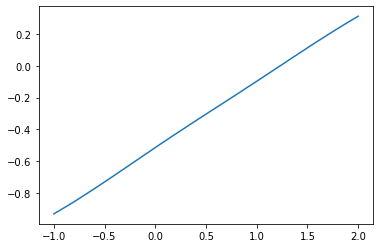

Epoch 0 with loss 4.368678569793701


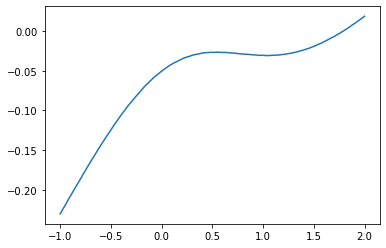

Epoch 500 with loss 0.11923092603683472


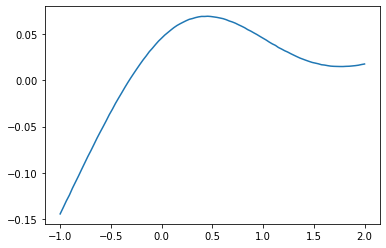

Epoch 1000 with loss 0.1096392348408699


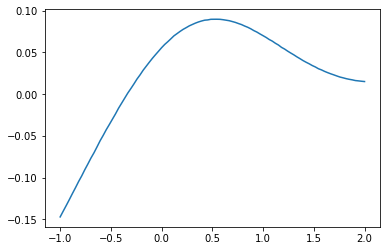

Epoch 1500 with loss 0.10495362430810928


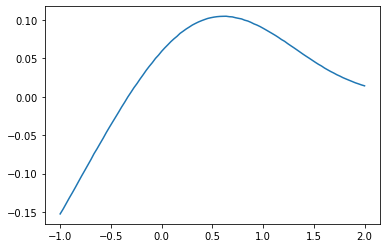

Epoch 2000 with loss 0.10371804982423782


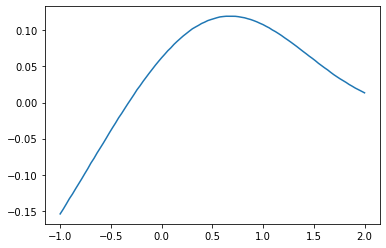

Epoch 2500 with loss 0.10179402679204941


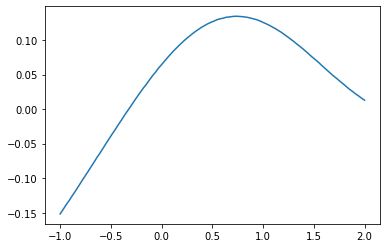

Epoch 3000 with loss 0.09844131022691727


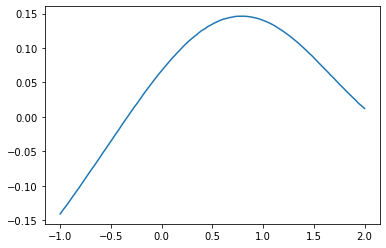

Epoch 3500 with loss 0.09383401274681091


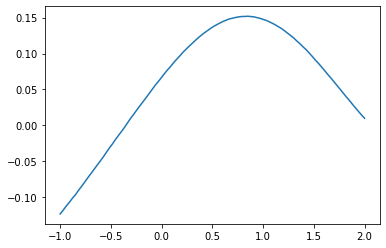

Epoch 4000 with loss 0.09355247765779495


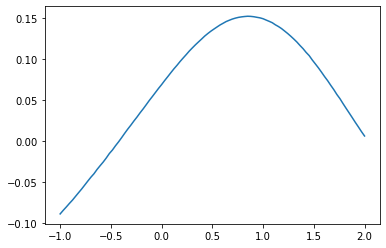

Epoch 4500 with loss 0.09043486416339874


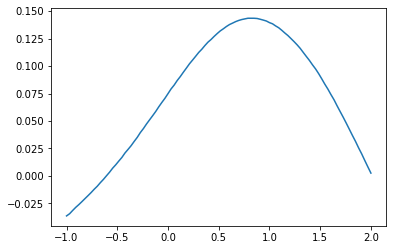

Epoch 5000 with loss 0.08446547389030457


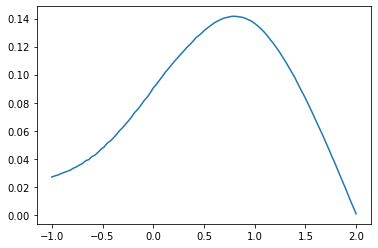

Epoch 5500 with loss 0.07782397419214249


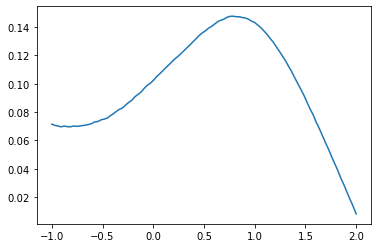

Epoch 6000 with loss 0.07417459040880203


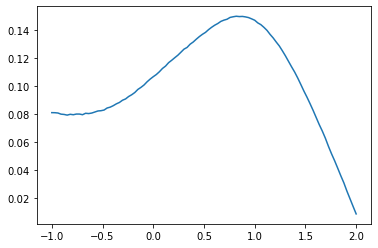

Epoch 6500 with loss 0.07086066156625748


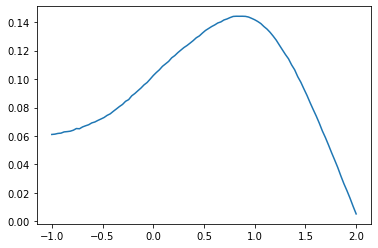

Epoch 7000 with loss 0.06356269121170044


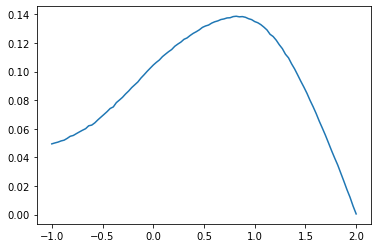

Epoch 7500 with loss 0.056263282895088196


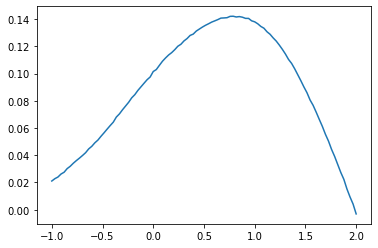

Epoch 8000 with loss 0.05006927251815796


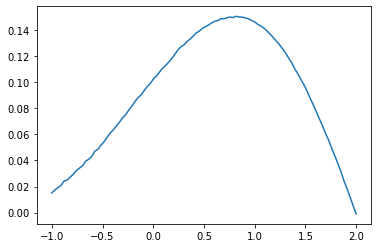

Epoch 8500 with loss 0.03991055488586426


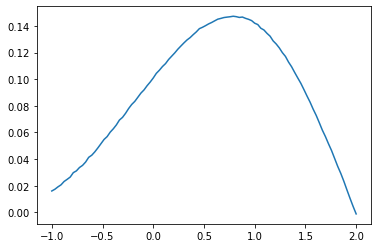

Epoch 9000 with loss 0.03220843896269798


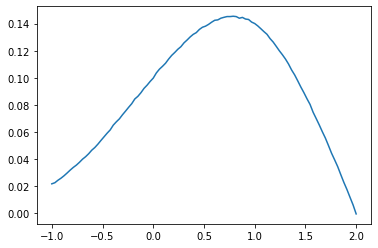

Epoch 9500 with loss 0.02545122057199478


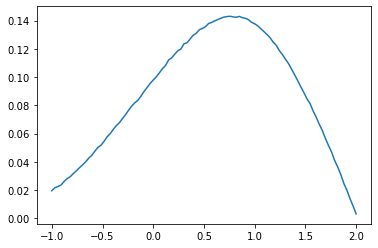

Epoch 9999 with loss 0.022177185863256454
Training of neural network with 10000 epochs take 148.87680578231812 seconds.


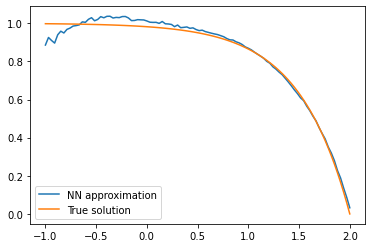

In [6]:
model = DGMNet(
    dgm_nb_states=10000,
    dgm_f_fun=f_example,
    dgm_deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    epochs=10000,
    dgm_lr=1e-4,
    overtrain_rate=0.,
    verbose=True,
    lambda_terminal=1.,
    lambda_boundary=10.,
)
model.train_and_eval(debug_mode=True)

nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device))
    .detach()
    .cpu()
    .numpy()
)
nn /= (norm.cdf(b - grid) - norm.cdf(a - grid))
plt.plot(grid, nn, label="NN approximation")
plt.plot(grid, true, label="True solution")
plt.legend()
plt.show()

In [7]:
tx, tx_term, tx_bound = model.gen_sample()

print(
    f"Terminal loss: {model.loss(model(tx_term.T), model.phi_fun(tx_term[1:, :])).item()}"
)
print(
    f"PDE loss: {model.pde_loss(tx)}"
)
print(
    f"Boundary loss: {model.loss(model(tx_bound.T), torch.zeros_like(tx_bound[1]))}"
)

Terminal loss: 0.019741717725992203
PDE loss: 0.0034045714419335127
Boundary loss: 1.012984193948796e-05
